# Overfitting and Regularization

## Imports

In [71]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.compose import ColumnTransformer


In [73]:
set_config(display='diagram')

## Settings

In [74]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [75]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

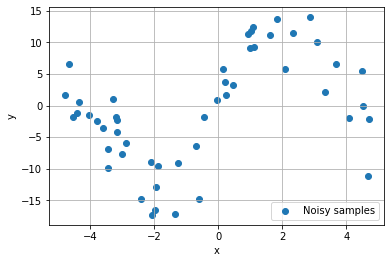

In [76]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

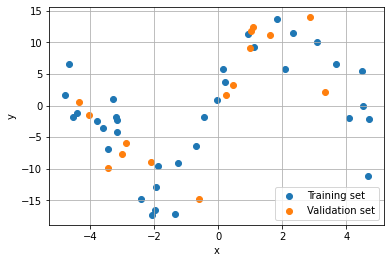

In [77]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [78]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [79]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

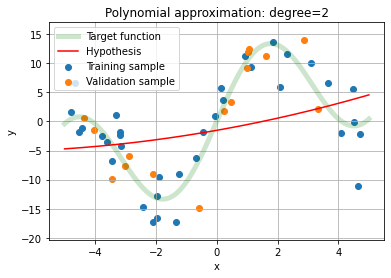

In [80]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

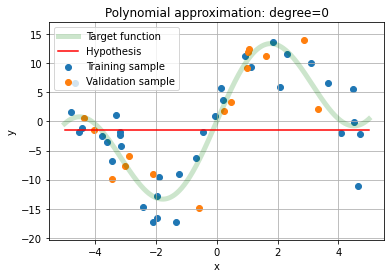

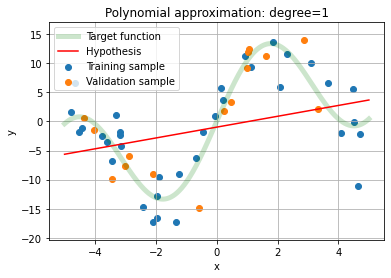

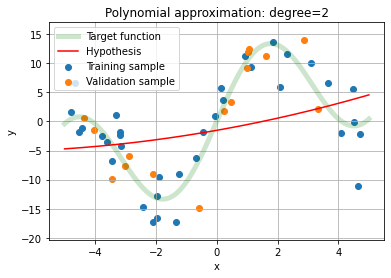

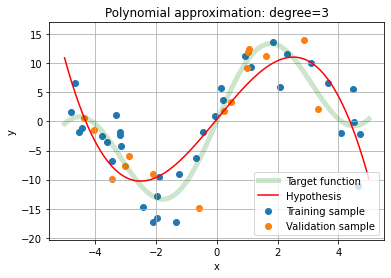

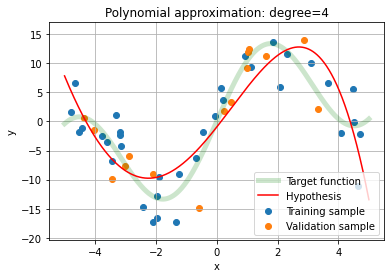

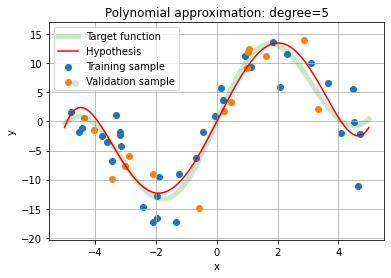

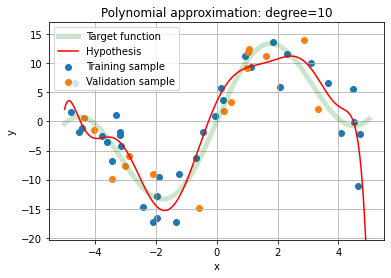

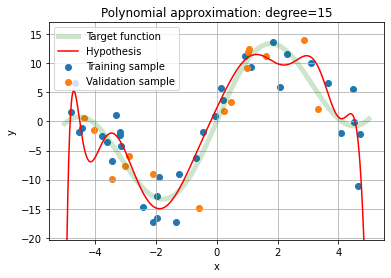

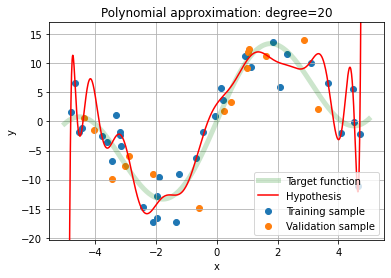

In [81]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

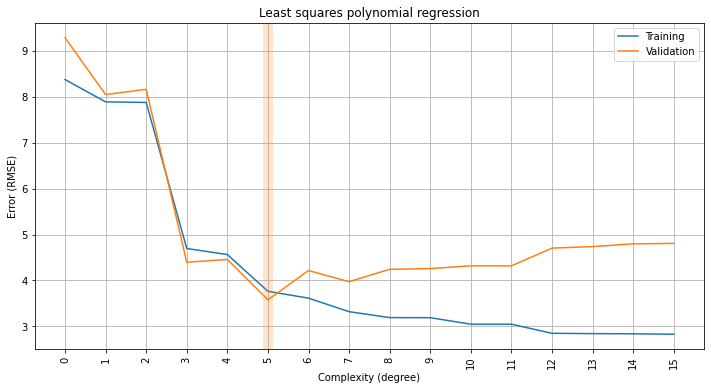

In [82]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(12, 6))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='upper right')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [83]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

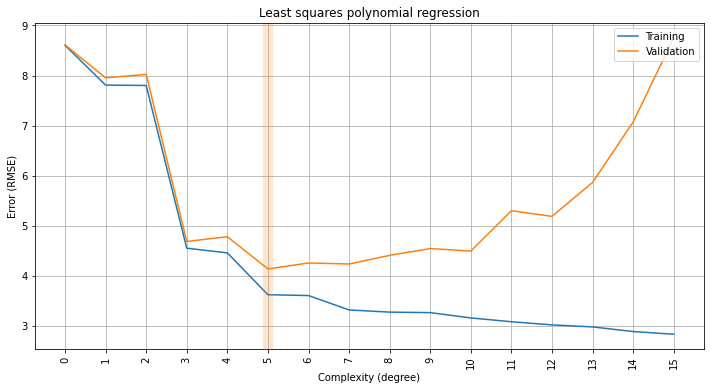

In [84]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [85]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

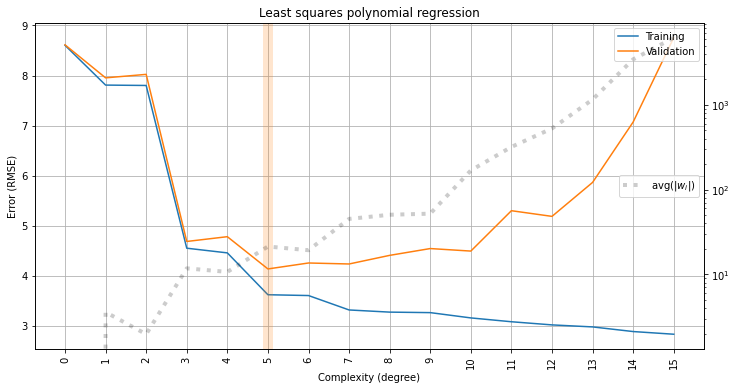

In [86]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

In [87]:
results['estimator']

[Pipeline(steps=[('pol', PolynomialFeatures(degree=15, include_bias=False)),
                 ('sca', StandardScaler()), ('reg', LinearRegression())]),
 Pipeline(steps=[('pol', PolynomialFeatures(degree=15, include_bias=False)),
                 ('sca', StandardScaler()), ('reg', LinearRegression())]),
 Pipeline(steps=[('pol', PolynomialFeatures(degree=15, include_bias=False)),
                 ('sca', StandardScaler()), ('reg', LinearRegression())]),
 Pipeline(steps=[('pol', PolynomialFeatures(degree=15, include_bias=False)),
                 ('sca', StandardScaler()), ('reg', LinearRegression())]),
 Pipeline(steps=[('pol', PolynomialFeatures(degree=15, include_bias=False)),
                 ('sca', StandardScaler()), ('reg', LinearRegression())])]

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

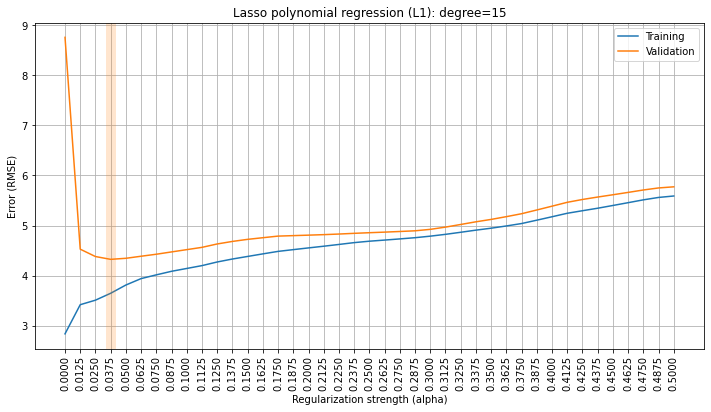

In [88]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

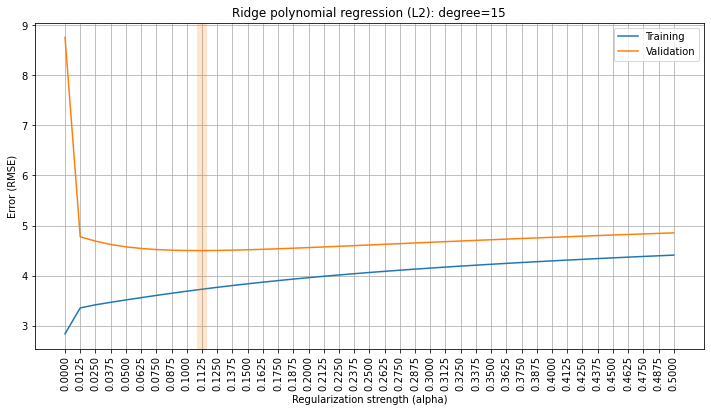

In [89]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [90]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

In [91]:
X_diabetes.describe()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-3.634285e-16,1.308343e-16,-8.045349e-16,1.281655e-16,-8.835316e-17,1.327024e-16,-4.574646e-16,3.777301e-16,-3.830854e-16,-3.412882e-16
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123996e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260974e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665645e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324879e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670611e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947634e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564384e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243323e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320442e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335990e-01,1.356118e-01


Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [92]:
DEGREES = DEGREES[DEGREES != 0] 

In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=SEED)
print("duplicated ", X_diabetes.duplicated().value_counts())
print("isna ",X_diabetes.isna().sum(axis=1).value_counts())


duplicated  False    442
dtype: int64
isna  0    442
dtype: int64


#### Т.к вычисление полиномеальной регрессии для множества признаков требует значительных вычислений, изменим функцию создания модели, передав ей массив со номерами признаков, которые будем полиномиризовать.

In [94]:
def make_model_small(degree, arr, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000, tol = 0.01)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', ColumnTransformer(transformers=[('cut', PolynomialFeatures(degree, include_bias=(degree == 0)), arr)], remainder='passthrough')),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

#### Имена признаков учавствующих в полиноме

In [95]:
print(X_diabetes[X_diabetes.columns[[0,1,2,3,4]]].columns.tolist())

['age', 'sex', 'bmi', 'bp', 's1']


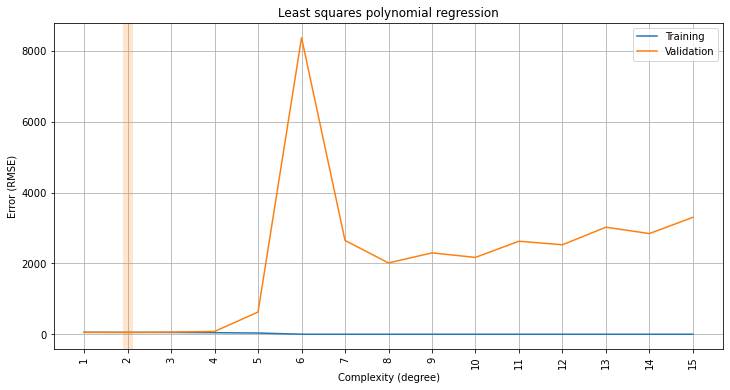

In [96]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    #print(make_model(degree))
    reg = make_model_small(degree,[0,1,2,3,4]).fit(X_train, y_train)
    
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [97]:
print("DEGREES at min.RMSE:", DEGREES[np.argmin(rmse_valid)])
print("Мин. rmse: ", np.min(rmse_valid))


DEGREES at min.RMSE: 2
Мин. rmse:  51.51471004362871


#### Увеличенный фрагмент с DEGREES = [1:3]

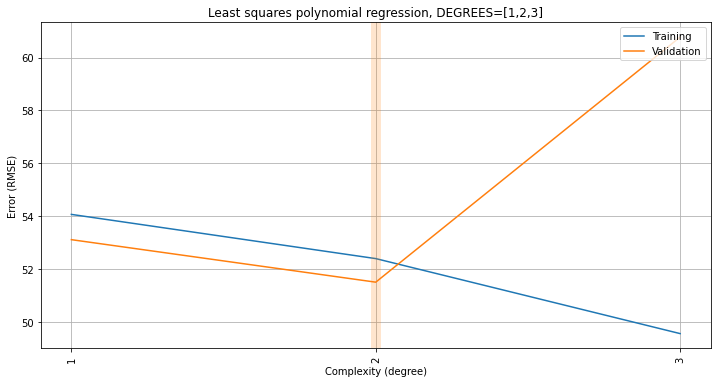

In [98]:
plot_fitting_graph(DEGREES[:3], rmse_train[:3], rmse_valid[:3], xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression, DEGREES=[1,2,3]')

1. **Underfitting** (degree < 2)
2. **Fit is just right** (degree = 2)
3. **Overfitting** (degree > 2)


#### Проделаем тоже самое с кроссвалидацией (cv=5)

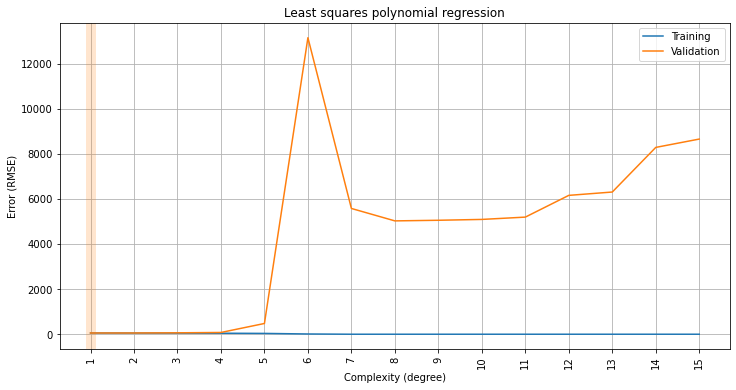

In [99]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model_small(degree,[0,1,2,3,4]), X_diabetes, y_diabetes, cv=5, \
                             return_train_score=True, return_estimator=True, \
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

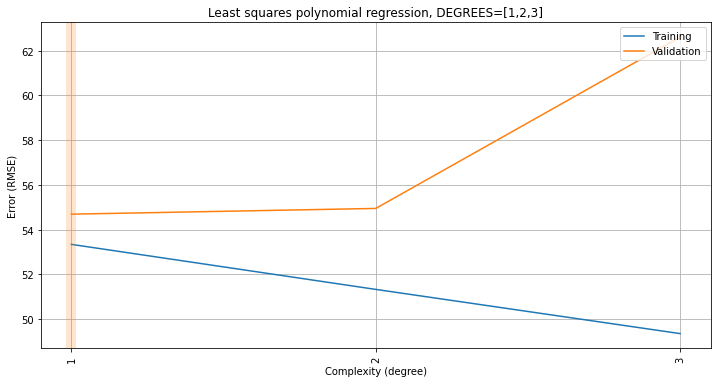

In [100]:
plot_fitting_graph(DEGREES[:3], rmse_train[:3], rmse_valid[:3], xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression, DEGREES=[1,2,3]')

In [101]:
print("DEGREES at min.RMSE:", DEGREES[np.argmin(rmse_valid)])
print("Мин. rmse: ", np.min(rmse_valid))


DEGREES at min.RMSE: 1
Мин. rmse:  54.69171350506142


1. **Fit is just right** (degree = 1)
2. **Overfitting** (degree > 1)


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

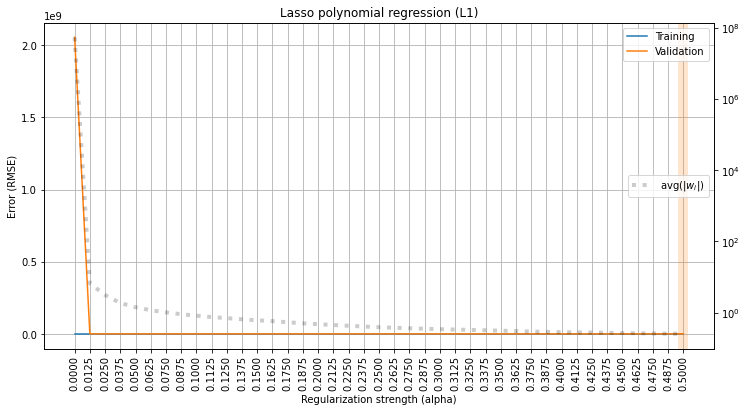

In [102]:
rmse_train_L1, rmse_valid_L1 , avg_coef_L1= [], [], []
coef_L1 = []
coef_L1_null = 0


degree = 15

for alpha in ALPHAS:    
    reg = make_model_small(degree,[0,1,2], penalty='L1', alpha=alpha).fit(X_train, y_train)
    rmse_train_L1.append(rmse(reg.predict(X_train), y_train))
    rmse_valid_L1.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef_L1.append(        
        np.mean([np.abs(reg['reg'].coef_)]))

#    print(reg['reg'].coef_)
    coef_L1_null=coef_L1_null + np.count_nonzero(np.abs(reg['reg'].coef_ == 0))

    coef_L1.extend(reg['reg'].coef_.tolist())


plot_fitting_graph(ALPHAS, rmse_train_L1, rmse_valid_L1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')    

In [103]:
print("Regularization strength (alpha) at min.RMSE", ALPHAS[np.argmin(rmse_valid_L1)])
print("Mean abs.value coefficients ( alpha=", ALPHAS[np.argmin(rmse_valid_L1)], ")", avg_coef_L1[np.argmin(rmse_valid_L1)])
#print(avg_coef_L2)
#np.count_nonzero(coef_L2 < np.finfo(np.float64).eps)


Regularization strength (alpha) at min.RMSE 0.5
Mean abs.value coefficients ( alpha= 0.5 ) 0.25512426302100355


#### L2

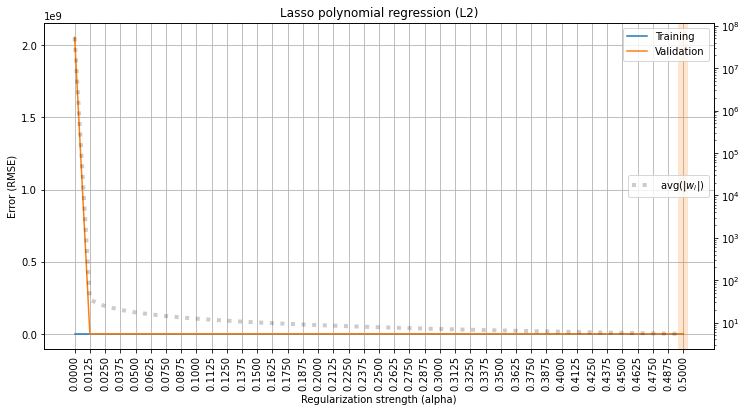

In [104]:
rmse_train_L2, rmse_valid_L2 , avg_coef_L2= [], [], []
coef_L2 = []
coef_L2_null = 0
degree = 15

for alpha in ALPHAS:    
    reg = make_model_small(degree,[0,1,2], penalty='L2', alpha=alpha).fit(X_train, y_train)
    rmse_train_L2.append(rmse(reg.predict(X_train), y_train))
    rmse_valid_L2.append(rmse(reg.predict(X_valid), y_valid))
    avg_coef_L2.append(        
        np.mean([np.abs(reg['reg'].coef_)]))

#    print(reg['reg'].coef_)
    coef_L2_null=coef_L2_null + np.count_nonzero(np.abs(reg['reg'].coef_ == 0))

    coef_L2.extend(reg['reg'].coef_.tolist())

plot_fitting_graph(ALPHAS, rmse_train_L2, rmse_valid_L2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L2, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L2)')    

In [105]:
print("Regularization strength (alpha) at min.RMSE", ALPHAS[np.argmin(rmse_valid_L2)])
print("Mean abs.value coefficients ( alpha=", ALPHAS[np.argmin(rmse_valid_L2)], ")", avg_coef_L1[np.argmin(rmse_valid_L2)])

Regularization strength (alpha) at min.RMSE 0.5
Mean abs.value coefficients ( alpha= 0.5 ) 0.25512426302100355


#### Наблюдаем  уменьшение среднего веса коэфициентов при L1 и L2 регуляризации

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### Выведем количество нулевых признаков для моделей из Task 2 (мы их посчитали заранее)

In [106]:
print("Count zero coef. at L1 reg.: ", coef_L1_null, "что состовляет", coef_L1_null/(len(coef_L1))*100, "%")
print("\nCount zero coef. at L2 reg.: ", coef_L2_null, "что состовляет", coef_L2_null/(len(coef_L2[1])*len(coef_L2))*100, "%")


Count zero coef. at L1 reg.:  28198 что состовляет 85.75773242906237 %

Count zero coef. at L2 reg.:  0 что состовляет 0.0 %


#### Уменьшим еще количество признаков в полиноме, чтобы получить приемлемое количество весов и выведем их график

#### L1

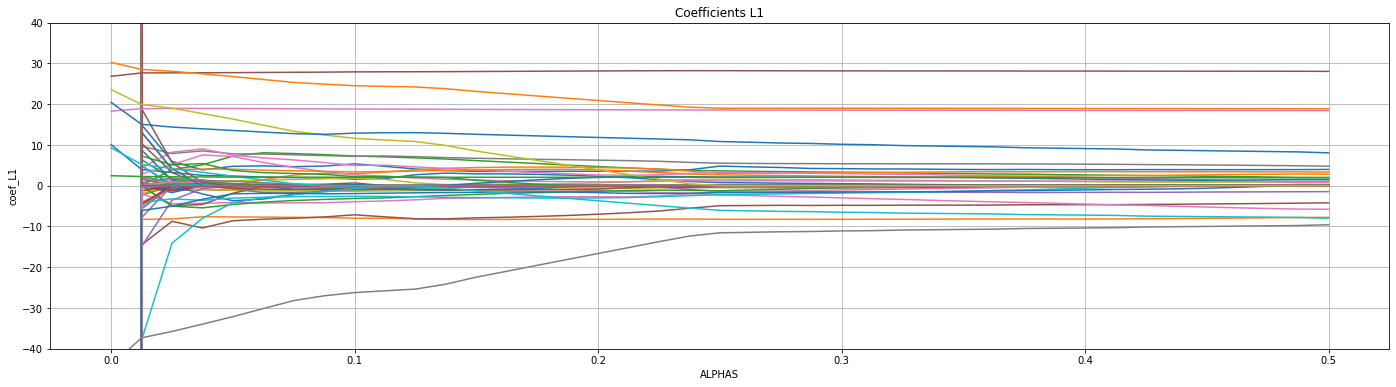

In [107]:
rmse_train_L1, rmse_valid_L1 , avg_coef_L1 = [], [], []
coef_L1 = np.empty([41,143])

degree = 15
for indx, alpha in enumerate(ALPHAS):    
    reg = make_model_small(degree,[0,1], penalty='L1', alpha=alpha).fit(X_train, y_train)
    coef_L1[indx,:]=reg['reg'].coef_

plt.figure(figsize=(24, 6))
plt.plot(ALPHAS,coef_L1[:,:])
plt.title("Coefficients L1")
plt.xlabel("ALPHAS")
plt.ylabel("coef_L1")
plt.grid(True)
plt.ylim(-40, 40)
plt.show()

#### L2

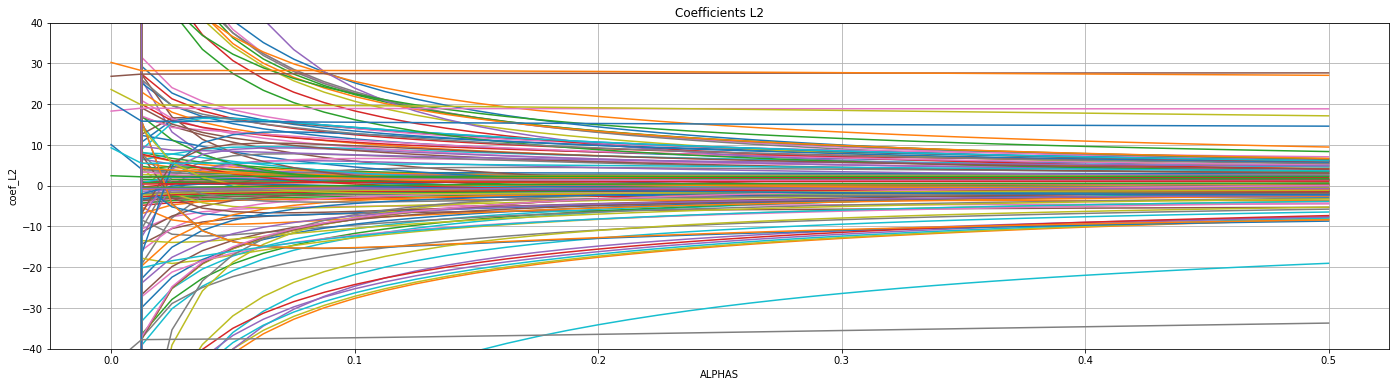

In [108]:
coef_L2 = np.empty([41,143])

degree = 15
for indx, alpha in enumerate(ALPHAS):    
    reg = make_model_small(degree,[0,1], penalty='L2', alpha=alpha).fit(X_train, y_train)
    coef_L2[indx,:]=reg['reg'].coef_

plt.figure(figsize=(24, 6))
plt.plot(ALPHAS,coef_L2[:,:])
plt.title("Coefficients L2")
plt.xlabel("ALPHAS")
plt.ylabel("coef_L2")
plt.grid(True)
plt.ylim(-40, 40)
plt.show()

#### Зануление весов при L2 не происходит, при L1 обнуляется значительная часть коэффициентов
##### Динамика изменений тоже разная

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [109]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


#### L1

In [110]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.3, random_state=SEED)

In [111]:
def make_model_no_scaler(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
      #  ('sca', StandardScaler()),
        ('reg', regressor)
    ])

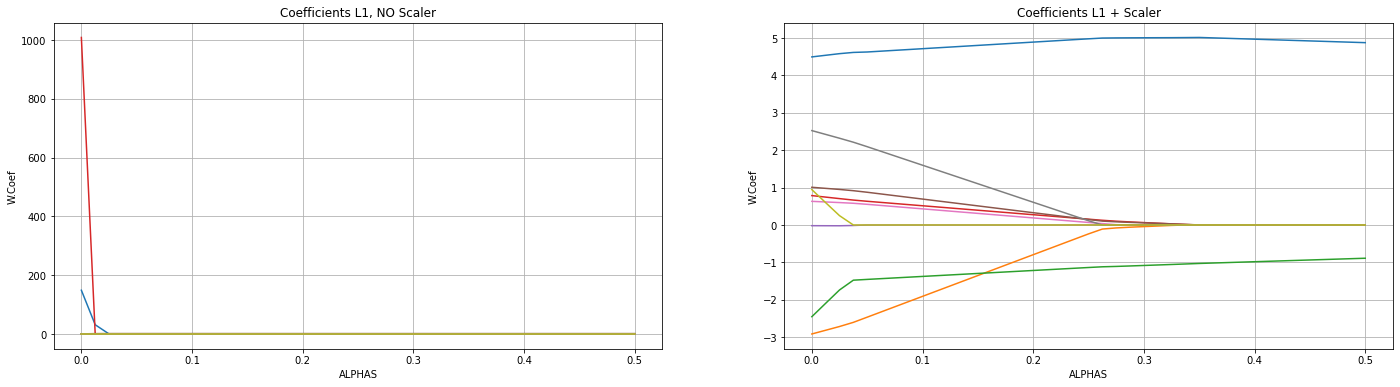

Count zero coef. at L1 reg. NO scaler data (Degree=2) 79, 21.41%
Count zero coef. at L1 reg. + scaler data (Degree=2) 152, 41.19%


In [112]:
rmse_train_L1, rmse_valid_L1 , avg_coef_L1= [], [], []
coef_L1 = []
coef_L1_NS = []
coef_L1_null = 0
coef_L1_null_NS = 0

degree = 2
for alpha in ALPHAS:    
    reg = make_model(degree, penalty='L1', alpha=alpha).fit(X_train, y_train)
    reg_NS = make_model_no_scaler(degree, penalty='L1', alpha=alpha).fit(X_train, y_train)
    coef_L1.append(reg['reg'].coef_)
    coef_L1_NS.append(reg_NS['reg'].coef_)
    coef_L1_null=coef_L1_null+np.count_nonzero(np.abs(reg['reg'].coef_ == 0))
    coef_L1_null_NS=coef_L1_null_NS+np.count_nonzero(np.abs(reg_NS['reg'].coef_ == 0))

plt.figure(figsize=(24, 6))


plt.subplot(1,2,1)
plt.title("Coefficients L1, NO Scaler")
plt.plot(ALPHAS,coef_L1_NS, label="NO Scaler")
plt.xlabel("ALPHAS")
plt.ylabel("W.Coef")
plt.grid(True)
#plt.legend(['1-Coef', '2-Coef', '3-Coef'])

plt.subplot(1,2,2)
plt.title("Coefficients L1 + Scaler")
plt.plot(ALPHAS,coef_L1, label="Scaler")
plt.xlabel("ALPHAS")
plt.ylabel("W.Coef")
plt.grid(True)
#plt.legend(['1-Coef', '2-Coef', '3-Coef'])

plt.show()
print(f'Count zero coef. at L1 reg. NO scaler data (Degree={degree}) {coef_L1_null_NS}, {(coef_L1_null_NS/(len(coef_L1_NS)*len(coef_L1_NS[0]))*100):.2f}%')
print(f'Count zero coef. at L1 reg. + scaler data (Degree={degree}) {coef_L1_null}, {(coef_L1_null/(len(coef_L1)*len(coef_L1[0]))*100):.2f}%')


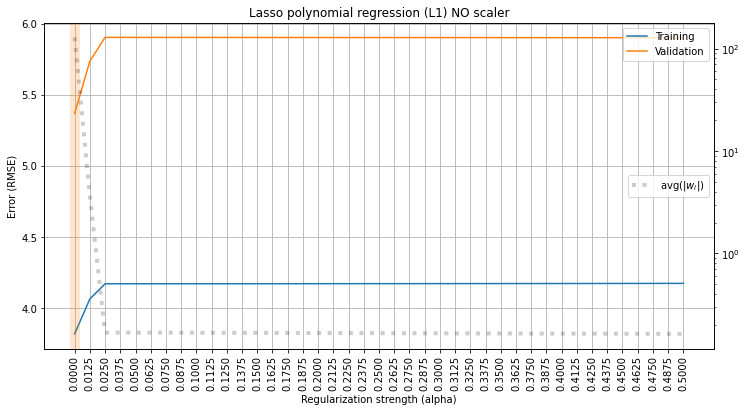

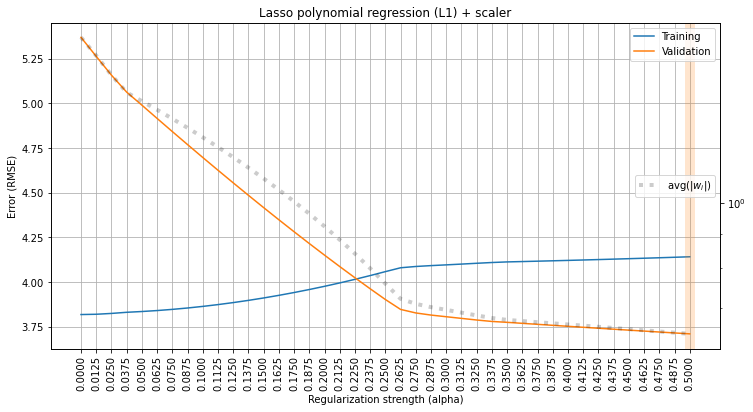

In [113]:
rmse_train_L1, rmse_valid_L1 , avg_coef_L1= [], [], []
rmse_train_L1_NS, rmse_valid_L1_NS , avg_coef_L1_NS= [], [], []

coef_L1 = []
coef_L1_NS = []

degree = 2
for alpha in ALPHAS: 
    reg = make_model(degree, penalty='L1', alpha=alpha).fit(X_train, y_train)
    reg_NS = make_model_no_scaler(degree, penalty='L1', alpha=alpha).fit(X_train, y_train)
    rmse_train_L1.append(rmse(reg.predict(X_train), y_train))
    rmse_valid_L1.append(rmse(reg.predict(X_valid), y_valid))
    rmse_train_L1_NS.append(rmse(reg_NS.predict(X_train), y_train))
    rmse_valid_L1_NS.append(rmse(reg_NS.predict(X_valid), y_valid))
    avg_coef_L1.append(        
        np.mean([np.abs(reg['reg'].coef_)]))
    avg_coef_L1_NS.append(        
        np.mean([np.abs(reg_NS['reg'].coef_)]))

plot_fitting_graph(ALPHAS, rmse_train_L1_NS, rmse_valid_L1_NS,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L1_NS, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1) NO scaler')   

plot_fitting_graph(ALPHAS, rmse_train_L1, rmse_valid_L1,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L1, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1) + scaler') 

#### L2

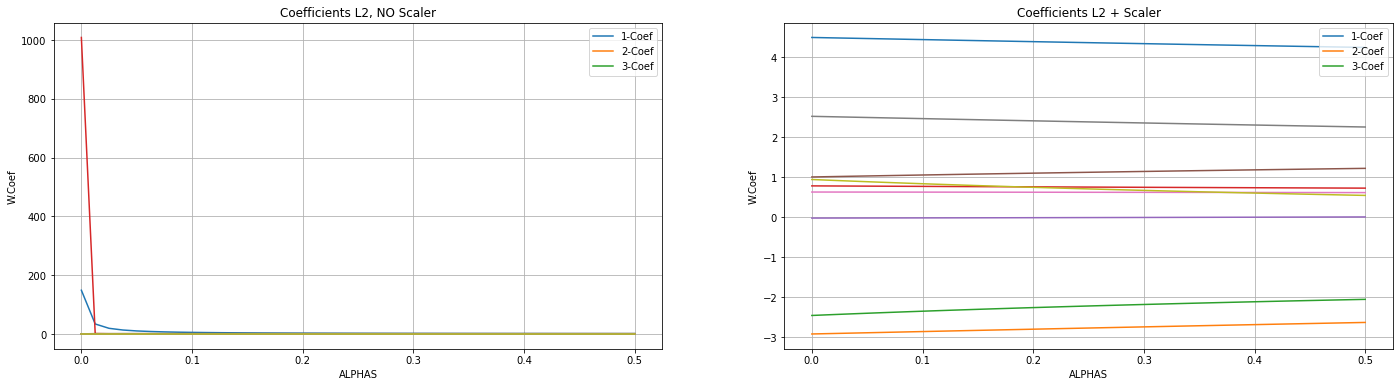

Count zero coef. at L1 reg. NO scaler data (Degree=2) 0, 0.00%
Count zero coef. at L1 reg. + scaler data (Degree=2) 0, 0.00%


In [114]:
rmse_train_L2, rmse_valid_L2, avg_coef_L2= [], [], []
coef_L2 = []
coef_L2_NS = []
coef_L2_null = 0
coef_L2_null_NS = 0

degree = 2
for alpha in ALPHAS:    
    reg = make_model(degree, penalty='L2', alpha=alpha).fit(X_train, y_train)
    reg_NS = make_model_no_scaler(degree, penalty='L2', alpha=alpha).fit(X_train, y_train)
    coef_L2.append(reg['reg'].coef_)
    coef_L2_NS.append(reg_NS['reg'].coef_)
    coef_L2_null=coef_L2_null+np.count_nonzero(np.abs(reg['reg'].coef_ == 0))
    coef_L2_null_NS=coef_L2_null_NS+np.count_nonzero(np.abs(reg_NS['reg'].coef_ == 0))
    

plt.figure(figsize=(24, 6))


plt.subplot(1,2,1)
plt.title("Coefficients L2, NO Scaler")
plt.plot(ALPHAS,coef_L2_NS, label="NO Scaler")
plt.xlabel("ALPHAS")
plt.ylabel("W.Coef")
plt.grid(True)
plt.legend(['1-Coef', '2-Coef', '3-Coef'])


plt.subplot(1,2,2)
plt.title("Coefficients L2 + Scaler")
plt.plot(ALPHAS,coef_L2, label="Scaler")
plt.xlabel("ALPHAS")
plt.ylabel("W.Coef")
plt.grid(True)
plt.legend(['1-Coef', '2-Coef', '3-Coef'])



plt.show()
print(f'Count zero coef. at L1 reg. NO scaler data (Degree={degree}) {coef_L2_null_NS}, {(coef_L2_null_NS/(len(coef_L2_NS)*len(coef_L2_NS[0]))*100):.2f}%')
print(f'Count zero coef. at L1 reg. + scaler data (Degree={degree}) {coef_L2_null}, {(coef_L2_null/(len(coef_L2)*len(coef_L2[0]))*100):.2f}%')

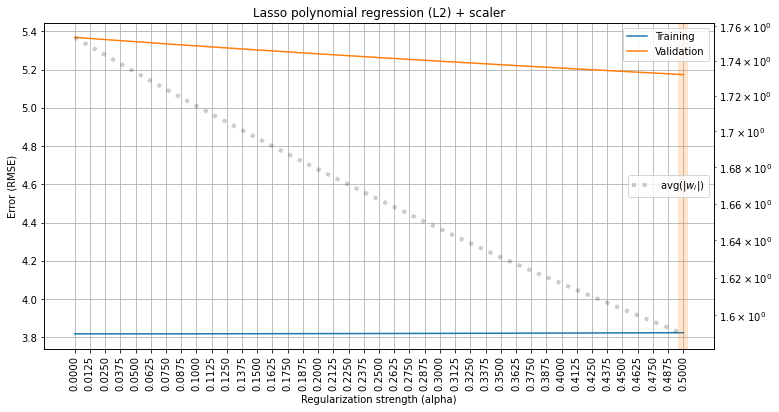

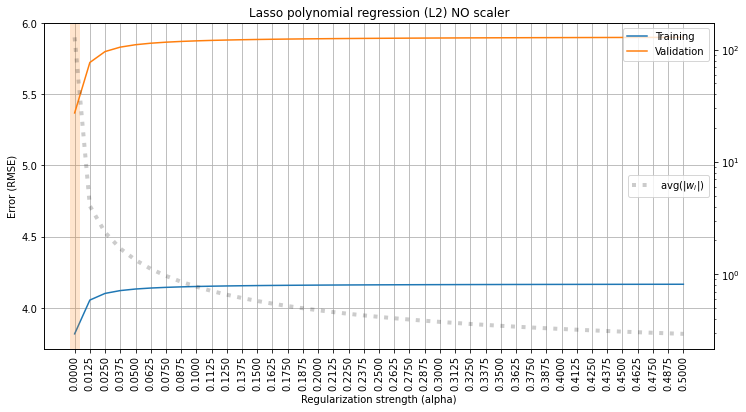

In [115]:
rmse_train_L2, rmse_valid_L2, avg_coef_L2 = [], [], []
rmse_train_L2_NS, rmse_valid_L2_NS , avg_coef_L2_NS= [], [], []

coef_L2 = []
coef_L2_NS = []

degree = 2
for alpha in ALPHAS: 
    reg = make_model(degree, penalty='L2', alpha=alpha).fit(X_train, y_train)
    reg_NS = make_model_no_scaler(degree, penalty='L2', alpha=alpha).fit(X_train, y_train)
    rmse_train_L2.append(rmse(reg.predict(X_train), y_train))
    rmse_valid_L2.append(rmse(reg.predict(X_valid), y_valid))
    rmse_train_L2_NS.append(rmse(reg_NS.predict(X_train), y_train))
    rmse_valid_L2_NS.append(rmse(reg_NS.predict(X_valid), y_valid))
    avg_coef_L2.append(        
        np.mean([np.abs(reg['reg'].coef_)]))
    avg_coef_L2_NS.append(        
        np.mean([np.abs(reg_NS['reg'].coef_)]))
plot_fitting_graph(ALPHAS, rmse_train_L2, rmse_valid_L2,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L2, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L2) + scaler') 
plot_fitting_graph(ALPHAS, rmse_train_L2_NS, rmse_valid_L2_NS,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef_L2_NS, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L2) NO scaler')   

#### Summary



##### Если входные данные не маштабированы, начальные веса  признаков имеют большой разброс, некоторые достаточно велики, что зкажется на устойчивости модели к шумам в данных. При регуляризации они снижаются, отрабатываются штрафы за высокий вес. С немаштабированными данными увеличение ALPHA при регуляризации приводит к увеличение RMSE, а в случае маштабированных к уменьшению. Похоже, что регуляризация данных не отрабатывает на нескалированных данных.